In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt


import pickle
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import gc
import time

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
full_path = "C:\Projects\EDA GSP"
df_path = os.path.join(full_path, "dataframes", "df_quantiles.pkl")

In [13]:
df = pd.read_pickle(df_path)

In [14]:
df.columns

Index(['session_id', 'index', 'event_name', 'name', 'level', 'page',
       'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'text',
       'fqid', 'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music',
       'level_group', 'elapsed_time_log', 'time_diff', 'elapsed_time_diff_log',
       'hover_duration_log', 'quantile'],
      dtype='object')

In [41]:
df["quantile"].describe()

count    2.554228e+07
mean     1.489684e+00
std      1.127214e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: quantile, dtype: float64

In [57]:
np.random.randint(0, 4)

2

In [4]:
pd.set_option('display.max_columns', None)

In [ ]:
df.columns

In [ ]:
df.info()

In [6]:
df = df.drop("elapsed_time",axis=1)
df = df.drop("hover_duration",axis=1)


KeyError: "['elapsed_time'] not found in axis"

In [8]:
df

,session_id,index,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,...,room_fqid,text_fqid,fullscreen,hq,music,level_group,elapsed_time_log,elapsed_time_diff_log,hover_duration_log,quantile
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0.0,0.0,NaN,0
1,20090312431273200,1,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,7.0,7.0,NaN,0
2,20090312431273200,2,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,6.5,0.0,NaN,0
3,20090312431273200,3,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,7.0,6.0,NaN,0
4,20090312431273200,4,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,...,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,7.5,6.5,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25542277,22100221145014656,1600,navigate_click,undefined,22,NaN,343.887299,36.701027,483.0,273.0,...,tunic.capitol_2.hall,NaN,0,0,1,13-22,15.5,7.0,NaN,2
25542278,22100221145014656,1601,navigate_click,undefined,22,NaN,332.696075,141.493179,545.0,221.0,...,tunic.capitol_2.hall,NaN,0,0,1,13-22,15.5,7.5,NaN,3
25542279,22100221145014656,1602,navigate_click,undefined,22,NaN,369.912872,140.569199,611.0,217.0,...,tunic.capitol_2.hall,NaN,0,0,1,13-22,15.5,6.5,NaN,3
25542280,22100221145014656,1603,navigate_click,undefined,22,NaN,252.299652,123.805893,526.0,232.0,...,tunic.capitol_2.hall,NaN,0,0,1,13-22,15.5,6.5,NaN,3


# Feature engineering

In [9]:
categ = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid', 'text']
numer = ["elapsed_time_log", "elapsed_time_diff_log", "hover_duration_log", 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', "page"]
binary = ["fullscreen", "hq", "music"]

In [15]:
df_0_4 = df[df['level_group'] == '0-4'].copy()
df_5_12 = df[df['level_group'] == '5-12'].copy()
df_13_22 = df[df['level_group'] == '13-22'].copy()

In [17]:
del df
gc.collect()

41

In [18]:
def feature_engineer(dataset_df):
    start_time = time.time()
    
    binary_groups = [] 
    for c in binary:
        tmp_binary_mean = dataset_df.groupby("session_id")[c].mean()
        binary_groups.append(tmp_binary_mean)

    print("Binary Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    groups = []
    
    # Calculating the total elapsed time for each session, level and quantile, transforming with log and adding 1
    elapsed_time = dataset_df.groupby(["session_id", "level", "quantile"])["time_diff"].sum()
    elapsed_time_log = np.log1p(elapsed_time) # apply log transformation and add 1
    elapsed_time_log.name = "quantile_elapsed"
    groups.append(elapsed_time_log)
    dataset_df = dataset_df.drop("time_diff",axis=1)

    del elapsed_time # release memory
    gc.collect() # collect garbage

    print("Elapsed Time por quantil Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    # Counting the number of events for each session, level and quantile
    event_count = dataset_df.groupby(["session_id", "level", "quantile"])["index"].count()
    event_count.name = "session_events"
    groups.append(event_count)

    print("Eventos por quantil Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    # Calculate the event density for each session, level and quantile
    event_density = np.where(elapsed_time_log > 0, event_count / elapsed_time_log, 0)
    # event_density = pd.Series(event_density, name='event_density')
    event_density = pd.Series(np.where(elapsed_time_log > 0, event_count / elapsed_time_log, 0), index=elapsed_time_log.index, name='event_density')
    groups.append(event_density)

    print("Densidad de eventos Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    del event_count, event_density # release memory
    gc.collect() # collect garbage

    for c in numer:
        if c == "hover_duration_log" or c == "page":
            tmp_mean = dataset_df.groupby(["session_id", "level", "quantile"])[c].mean()
            tmp_mean = tmp_mean.fillna(-1 if c == "page" else 0)
            tmp_std = dataset_df.groupby(["session_id", "level", "quantile"])[c].std(ddof=0)
            tmp_std = tmp_std.fillna(-1 if c == "page" else 0)  # fill NaN with -1 for 'page', 0 for others
            tmp_std.name = tmp_std.name + '_std'
            groups.append(tmp_mean)
            groups.append(tmp_std)

            del tmp_mean, tmp_std # release memory
            gc.collect() # collect garbage
        else:
            tmp_mean = dataset_df.groupby(["session_id", "level", "quantile"])[c].mean()
            tmp_std =  dataset_df.groupby(["session_id", "level", "quantile"])[c].std(ddof=0)
            tmp_std.name = tmp_std.name + '_std'
            groups.append(tmp_mean)
            groups.append(tmp_std)
            del tmp_mean, tmp_std # release memory
            gc.collect() # collect garbage

        print(f"{c} Completado. Tiempo transcurrido: {time.time() - start_time:.2f} segundos")
        print()

    for c in categ: 
        tmp_cat = dataset_df.groupby(["session_id", "level", "quantile"])[c].agg("nunique")
        groups.append(tmp_cat)
        del tmp_cat # release memory
        gc.collect() # collect garbage
        print(f"{c} Completado. Tiempo transcurrido: {time.time() - start_time:.2f} segundos")
        print()
    df_unstacked = pd.concat(groups, axis=1).unstack(['level',"quantile"])
    df_unstacked.columns = ['_'.join(map(str, col)).rstrip('_') for col in df_unstacked.columns.values]

    print("Unstack Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    del groups # release memory
    gc.collect() # collect garbage

    df_binary = pd.concat(binary_groups, axis=1)
    df_binary.columns = binary

    print("Binary concatenado Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    del binary_groups # release memory
    gc.collect() # collect garbage

    df_final = pd.merge(df_unstacked, df_binary, left_index=True, right_index=True)

    print("Merge Completado. Tiempo transcurrido: {:.2f} segundos".format(time.time() - start_time))
    print()

    del df_unstacked, df_binary # release memory
    gc.collect() # collect garbage

    df_final = df_final.fillna(-1)

    return df_final


In [19]:
df_1 = feature_engineer(df_0_4)

Binary Completado. Tiempo transcurrido: 0.40 segundos

Elapsed Time por quantil Completado. Tiempo transcurrido: 0.94 segundos

Eventos por quantil Completado. Tiempo transcurrido: 1.32 segundos

Densidad de eventos Completado. Tiempo transcurrido: 1.39 segundos

elapsed_time_log Completado. Tiempo transcurrido: 2.30 segundos

elapsed_time_diff_log Completado. Tiempo transcurrido: 3.23 segundos

hover_duration_log Completado. Tiempo transcurrido: 4.15 segundos

room_coor_x Completado. Tiempo transcurrido: 5.15 segundos

room_coor_y Completado. Tiempo transcurrido: 6.09 segundos

screen_coor_x Completado. Tiempo transcurrido: 7.15 segundos

screen_coor_y Completado. Tiempo transcurrido: 8.21 segundos

page Completado. Tiempo transcurrido: 9.13 segundos

event_name Completado. Tiempo transcurrido: 10.18 segundos

name Completado. Tiempo transcurrido: 10.89 segundos

fqid Completado. Tiempo transcurrido: 11.73 segundos

room_fqid Completado. Tiempo transcurrido: 12.44 segundos

text_fqid 

In [20]:
df_1.head(3)

,quantile_elapsed_0_0,quantile_elapsed_0_1,quantile_elapsed_0_2,quantile_elapsed_0_3,quantile_elapsed_1_0,quantile_elapsed_1_1,quantile_elapsed_1_2,quantile_elapsed_1_3,quantile_elapsed_2_0,quantile_elapsed_2_1,...,text_3_1,text_3_2,text_3_3,text_4_0,text_4_1,text_4_2,text_4_3,fullscreen,hq,music
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,8.646466,8.966229,8.756368,8.762020,9.373054,9.202107,9.302737,8.884056,9.128913,9.230241,...,1,0,4,0,0,0,0,0.0,0.0,1.0
20090312433251036,7.049255,8.071531,8.192017,8.553718,10.194888,8.866017,8.094378,8.289791,9.821138,10.326498,...,0,0,4,0,0,0,0,0.0,0.0,0.0
20090312455206810,7.446001,7.666222,7.895808,8.464636,12.298146,9.497922,8.507749,8.050065,7.972811,9.441531,...,0,1,3,0,0,0,0,1.0,1.0,1.0


In [25]:
list(df_1.columns)

['quantile_elapsed_0_0',
 'quantile_elapsed_0_1',
 'quantile_elapsed_0_2',
 'quantile_elapsed_0_3',
 'quantile_elapsed_1_0',
 'quantile_elapsed_1_1',
 'quantile_elapsed_1_2',
 'quantile_elapsed_1_3',
 'quantile_elapsed_2_0',
 'quantile_elapsed_2_1',
 'quantile_elapsed_2_2',
 'quantile_elapsed_2_3',
 'quantile_elapsed_3_0',
 'quantile_elapsed_3_1',
 'quantile_elapsed_3_2',
 'quantile_elapsed_3_3',
 'quantile_elapsed_4_0',
 'quantile_elapsed_4_1',
 'quantile_elapsed_4_2',
 'quantile_elapsed_4_3',
 'session_events_0_0',
 'session_events_0_1',
 'session_events_0_2',
 'session_events_0_3',
 'session_events_1_0',
 'session_events_1_1',
 'session_events_1_2',
 'session_events_1_3',
 'session_events_2_0',
 'session_events_2_1',
 'session_events_2_2',
 'session_events_2_3',
 'session_events_3_0',
 'session_events_3_1',
 'session_events_3_2',
 'session_events_3_3',
 'session_events_4_0',
 'session_events_4_1',
 'session_events_4_2',
 'session_events_4_3',
 'event_density_0_0',
 'event_density_0_

In [21]:
df_2 = feature_engineer(df_5_12)

Binary Completado. Tiempo transcurrido: 0.67 segundos

Elapsed Time por quantil Completado. Tiempo transcurrido: 1.74 segundos

Eventos por quantil Completado. Tiempo transcurrido: 2.65 segundos

Densidad de eventos Completado. Tiempo transcurrido: 2.76 segundos

elapsed_time_log Completado. Tiempo transcurrido: 4.74 segundos

elapsed_time_diff_log Completado. Tiempo transcurrido: 7.07 segundos

hover_duration_log Completado. Tiempo transcurrido: 9.49 segundos

room_coor_x Completado. Tiempo transcurrido: 11.23 segundos

room_coor_y Completado. Tiempo transcurrido: 13.28 segundos

screen_coor_x Completado. Tiempo transcurrido: 15.52 segundos

screen_coor_y Completado. Tiempo transcurrido: 17.76 segundos

page Completado. Tiempo transcurrido: 19.50 segundos

event_name Completado. Tiempo transcurrido: 21.19 segundos

name Completado. Tiempo transcurrido: 22.66 segundos

fqid Completado. Tiempo transcurrido: 24.45 segundos

room_fqid Completado. Tiempo transcurrido: 26.04 segundos

text_

In [26]:
df_3 = feature_engineer(df_13_22)

Binary Completado. Tiempo transcurrido: 1.02 segundos

Elapsed Time por quantil Completado. Tiempo transcurrido: 2.72 segundos

Eventos por quantil Completado. Tiempo transcurrido: 3.94 segundos

Densidad de eventos Completado. Tiempo transcurrido: 4.12 segundos

elapsed_time_log Completado. Tiempo transcurrido: 6.93 segundos

elapsed_time_diff_log Completado. Tiempo transcurrido: 9.55 segundos

hover_duration_log Completado. Tiempo transcurrido: 12.10 segundos

room_coor_x Completado. Tiempo transcurrido: 14.74 segundos

room_coor_y Completado. Tiempo transcurrido: 17.32 segundos

screen_coor_x Completado. Tiempo transcurrido: 19.86 segundos

screen_coor_y Completado. Tiempo transcurrido: 22.33 segundos

page Completado. Tiempo transcurrido: 24.71 segundos

event_name Completado. Tiempo transcurrido: 27.13 segundos

name Completado. Tiempo transcurrido: 29.29 segundos

fqid Completado. Tiempo transcurrido: 32.07 segundos

room_fqid Completado. Tiempo transcurrido: 34.67 segundos

text

In [27]:
del df_0_4, df_5_12, df_13_22
gc.collect()

21

In [39]:
df_2.columns

Index(['quantile_elapsed_5_0', 'quantile_elapsed_5_1', 'quantile_elapsed_5_2',
       'quantile_elapsed_5_3', 'quantile_elapsed_6_0', 'quantile_elapsed_6_1',
       'quantile_elapsed_6_2', 'quantile_elapsed_6_3', 'quantile_elapsed_7_0',
       'quantile_elapsed_7_1',
       ...
       'text_11_1', 'text_11_2', 'text_11_3', 'text_12_0', 'text_12_1',
       'text_12_2', 'text_12_3', 'fullscreen', 'hq', 'music'],
      dtype='object', length=803)

## Scaler

In [ ]:
scaler = StandardScaler()

In [ ]:
df_scaled = scaler.fit_transform(df_nuevo)

In [ ]:
df_nuevo["elapsed_time_log_4_3"].describe()

# Labels

In [28]:
ALL_USERS = df_1.index.values

In [29]:
len(ALL_USERS)

22936

In [30]:
target_path = os.path.join(full_path, "data", "train_labels.csv")
labels = pd.read_csv(target_path)

In [ ]:
labels

In [31]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [32]:
labels

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [ ]:
# labels = labels.rename(columns={"session_id":"session"})

In [ ]:
# labels[['session_id', 'question']] = labels['session'].str.split('_', expand=True)

# labels = labels.drop(columns=['session'])

# labels = labels.pivot(index='session_id', columns='question', values='correct')

In [ ]:
# labels.index = labels.index.astype("int64")

In [ ]:
# questions_1_3 = ["q1", "q2", "q3"]
# questions_4_13 = ["q4", "q5", "q6", "q7", "q8", "q9", "q10", "q11", "q12", "q13"]
# questions_14_18 = ["q14", "q15", "q16", "q17", "q18"]

In [ ]:
# labels_1_3 = labels[questions_1_3].copy()
# labels_4_13 = labels[questions_4_13].copy()
# labels_14_18 = labels[questions_14_18].copy()

# Model training and feature importance

In [ ]:
# Assuming that your dataframe df_nuevo is already defined and preprocessed
X = df_nuevo.copy()
y = labels["q1"].copy()

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Initialize the model
model = lgb.LGBMClassifier()

# Arrays to store scores
oof_preds = np.zeros(X.shape[0])
feature_importances = np.zeros(X.shape[1])

# Loop for each fold
for train_index, valid_index in gkf.split(X, y, groups=df_nuevo.index):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    # Get predictions
    oof_preds[valid_index] = model.predict_proba(X_valid)[:, 1]

    # Get feature importance
    feature_importances += model.feature_importances_ / 5  # Assuming 5 folds

# Compute the score
auc_score = roc_auc_score(y, oof_preds)
f1_sc = f1_score(y, oof_preds.round())
print(f"AUC: {auc_score}, F1: {f1_sc}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances,
}).sort_values(by='importance', ascending=False)
print(importance_df)

In [ ]:
X = df_nuevo.copy()
y = labels["q1"].copy()

In [ ]:
X, y = X.align(y, join='inner', axis=0)

In [ ]:
# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Initialize the model
model = lgb.LGBMClassifier()

# Arrays to store scores
oof_preds = np.zeros(X.shape[0])
feature_importances = np.zeros(X.shape[1])

In [ ]:
X_scaled = df_scaled.copy()

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, index=df_nuevo.index, columns=df_nuevo.columns)

In [ ]:
X_scaled_df, y = X_scaled_df.align(y, join='inner', axis=0)

In [ ]:
# Initialize GroupKFold
gkf_2 = GroupKFold(n_splits=5)

# Initialize the model
model_2 = lgb.LGBMClassifier()

# Arrays to store scores
oof_preds_2 = np.zeros(X.shape[0])
feature_importances_2 = np.zeros(X.shape[1])

In [ ]:
# Loop for each fold
for train_index, valid_index in gkf.split(X, y, groups=df_nuevo.index):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    # Get predictions
    oof_preds[valid_index] = model.predict_proba(X_valid)[:, 1]

    # Get feature importance
    feature_importances += model.feature_importances_ / 5  # Assuming 5 folds


In [ ]:
# Loop for each fold
for train_index, valid_index in gkf_2.split(X_scaled_df, y, groups=df_nuevo.index):
    X_train, X_valid = X_scaled_df.iloc[train_index], X_scaled_df.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Train the model
    model_2.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    # Get predictions
    oof_preds_2[valid_index] = model_2.predict_proba(X_valid)[:, 1]

    # Get feature importance
    feature_importances_2 += model_2.feature_importances_ / 5  # Assuming 5 folds


In [ ]:
# Feature importance
importance_df_2 = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'importance': feature_importances_2,
}).sort_values(by='importance', ascending=False)
print(importance_df_2)

In [ ]:
len(importance_df_2[importance_df_2["importance"]>10])

In [ ]:
del f1_score

In [ ]:
auc_score = roc_auc_score(y, oof_preds)
f1_sc = f1_score(y, oof_preds.round())
print(f"AUC: {auc_score}, F1: {f1_sc}")

In [ ]:
# Compute the score
auc_score = roc_auc_score(y, oof_preds)
f1_sc = f1_score(y, oof_preds.round())
print(f"AUC: {auc_score}, F1: {f1_sc}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances,
}).sort_values(by='importance', ascending=False)
print(importance_df)

In [ ]:
len(importance_df[importance_df["importance"]>10])

## Save importances

In [ ]:
# Define the output directory and file
output_dir_importances = os.path.join(full_path, 'importances')
if not os.path.exists(output_dir_importances):  # create the directory if it doesn't exist
    os.makedirs(output_dir_importances)
output_file = os.path.join(output_dir_importances, 'importance_q1_sc.pkl')
# Save dataframe to pickle file
importance_df_2.to_pickle(output_file)

In [ ]:
importance_df[importance_df["importance"]>10]

In [ ]:
del f1_score

In [ ]:
# Initialize arrays for scores and thresholds
scores = []
thresholds = []
best_score = 0
best_threshold = 0

# Calculate AUC
auc_score = roc_auc_score(y, oof_preds)
print(f'Overall AUC: {auc_score}')

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof_preds > threshold).astype('int')
    f1 = f1_score(y, preds, average='macro')   
    scores.append(f1)
    thresholds.append(threshold)
    if f1 > best_score:
        best_score = f1
        best_threshold = threshold

print()
print(f'Best F1 score {best_score} at threshold {best_threshold}')

In [ ]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [ ]:
scores = []
thresholds = []
best_score = 0
best_threshold = 0

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof_preds > threshold).astype('int')
    f1 = f1_score(y, preds, average='binary')  # 'binary' instead of 'macro'
    scores.append(f1)
    thresholds.append(threshold)
    if f1 > best_score:
        best_score = f1
        best_threshold = threshold

print()
print(f'Best F1 score {best_score} at threshold {best_threshold}')

In [ ]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

# Model Training 2

In [33]:
def user_split(dataset, random_seed=42):
    np.random.seed(random_seed)
    USER_LIST = dataset.index.unique()
    USER_LIST = np.random.permutation(USER_LIST)
    return USER_LIST

In [34]:
USER_SPLIT = user_split(df_1)

In [35]:
def split_dataset(dataset, USER_LIST, test_ratio=0.20):    
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]


In [36]:
train_x_1, valid_x_1 = split_dataset(df_1, USER_SPLIT)
print("{} examples in training, {} examples in testing.".format(
    len(train_x_1), len(valid_x_1)))

18348 examples in training, 4588 examples in testing.


In [37]:
train_x_2, valid_x_2 = split_dataset(df_2, USER_SPLIT)
print("{} examples in training, {} examples in testing.".format(
    len(train_x_2), len(valid_x_2)))

18348 examples in training, 4588 examples in testing.


In [38]:
train_x_3, valid_x_3 = split_dataset(df_3, USER_SPLIT)
print("{} examples in training, {} examples in testing.".format(
    len(train_x_3), len(valid_x_3)))

18348 examples in training, 4588 examples in testing.


In [39]:
VALID_USER_LIST = valid_x_1.index.unique()

In [40]:
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [ ]:
# group_dic = {"0-4":[0,1,2,3,4],"5-12":[5,6,7,8,9,10,11,12],"13-22":[13,14,15,16,17,18,19,20,21,22]}

In [41]:
dataframes = {
    "0-4": (train_x_1, valid_x_1),
    "5-12": (train_x_2, valid_x_2),
    "13-22": (train_x_3, valid_x_3),
}

In [42]:
dataframes_2 = {
    "0-4": df_1,
    "5-12": df_2,
    "13-22": df_3,
}

## Importance_df

In [75]:
# Dictionary to store feature importances for each question
feature_importances_dict = {}

for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    df = dataframes_2[grp]

    # Select the labels for the related q_no.
    targets = labels.loc[labels.q==q_no].set_index('session').loc[df.index]

    # Define model
    model = ExtraTreesClassifier()

    # Fit model
    model.fit(df, targets['correct'])

    # Get feature importances
    importances = model.feature_importances_

    # Store feature importances in dictionary
    feature_importances_dict[q_no] = pd.Series(importances, index=df.columns)

# At this point, `feature_importances_dict` contains the feature importances for each question


### q_no 1 grp 0-4
### q_no 2 grp 0-4
### q_no 3 grp 0-4


KeyboardInterrupt: 

In [76]:
importance_df_path = os.path.join(full_path, "dataframes", "importances_df.pkl")
importances_df = pd.read_pickle(importance_df_path)

In [77]:
importances_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
elapsed_time_diff_log_0_0,0.002784,0.002926,0.002521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elapsed_time_diff_log_0_1,0.002443,0.002934,0.002385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elapsed_time_diff_log_0_2,0.002293,0.002069,0.002295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elapsed_time_diff_log_0_3,0.002462,0.002301,0.002735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elapsed_time_diff_log_10_0,NaN,NaN,NaN,0.001303,0.001250,0.001250,0.001425,0.001300,0.001276,0.001248,0.001372,0.001444,0.001516,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
text_fqid_8_3,NaN,NaN,NaN,0.001147,0.001350,0.001277,0.001254,0.001264,0.001262,0.001253,0.001282,0.001378,0.001303,NaN,NaN,NaN,NaN,NaN
text_fqid_9_0,NaN,NaN,NaN,0.001037,0.001136,0.001309,0.001179,0.001167,0.001422,0.001299,0.001433,0.001124,0.001142,NaN,NaN,NaN,NaN,NaN
text_fqid_9_1,NaN,NaN,NaN,0.001155,0.000959,0.001219,0.001263,0.000982,0.001030,0.000846,0.000925,0.001069,0.000935,NaN,NaN,NaN,NaN,NaN
text_fqid_9_2,NaN,NaN,NaN,0.001431,0.001257,0.001312,0.001270,0.001413,0.001605,0.001449,0.001541,0.001322,0.001459,NaN,NaN,NaN,NaN,NaN


In [73]:
# importances_df = pd.DataFrame(feature_importances_dict)

In [79]:
prueba_df = importances_df[1].sort_values(ascending=False).to_frame()

In [80]:
prueba_df.head(10)

,1
quantile_elapsed_4_3,0.005819
name_3_0,0.005026
session_events_3_0,0.003780
session_events_3_2,0.003761
elapsed_time_diff_log_1_2,0.003651
session_events_3_3,0.003547
text_3_0,0.003501
elapsed_time_diff_log_2_3,0.003485
elapsed_time_diff_log_1_1,0.003383
event_density_3_0,0.003377


# 10 primeras feature_importance de cada question

In [107]:
importances_df[1].sort_values(ascending=False).to_frame().head(5)

,1
quantile_elapsed_4_3,0.005819
name_3_0,0.005026
session_events_3_0,0.003780
session_events_3_2,0.003761
elapsed_time_diff_log_1_2,0.003651


In [108]:
importances_df[2].sort_values(ascending=False).to_frame().head(5)

,2
quantile_elapsed_4_3,0.004685
elapsed_time_log_std_4_3,0.004438
elapsed_time_diff_log_std_2_3,0.003805
elapsed_time_diff_log_2_3,0.003658
room_coor_y_4_1,0.003408


In [109]:
importances_df[3].sort_values(ascending=False).to_frame().head(5)

,3
quantile_elapsed_4_3,0.004749
event_density_3_0,0.003232
event_density_3_2,0.003228
elapsed_time_log_std_4_3,0.003219
room_coor_y_std_3_2,0.003213


In [110]:
importances_df[4].sort_values(ascending=False).to_frame().head(5)

,4
elapsed_time_diff_log_10_3,0.006126
elapsed_time_diff_log_8_2,0.006060
elapsed_time_diff_log_std_6_3,0.003977
elapsed_time_diff_log_std_8_2,0.003694
elapsed_time_diff_log_7_2,0.003572


In [111]:
importances_df[5].sort_values(ascending=False).to_frame().head(5)

,5
event_density_11_3,0.003487
event_name_11_1,0.003473
session_events_11_1,0.003083
room_coor_x_std_11_1,0.003000
screen_coor_x_std_11_1,0.002979


In [112]:
importances_df[6].sort_values(ascending=False).to_frame().head(5)

,6
room_coor_x_std_11_1,0.003649
event_name_11_1,0.003544
session_events_11_0,0.003217
fqid_11_1,0.003097
session_events_11_2,0.003034


In [113]:
importances_df[7].sort_values(ascending=False).to_frame().head(5)

,7
fqid_11_1,0.002639
session_events_11_1,0.002622
elapsed_time_diff_log_8_2,0.002390
room_coor_x_std_11_1,0.002369
event_name_11_1,0.002368


In [114]:
importances_df[8].sort_values(ascending=False).to_frame().head(5)

,8
elapsed_time_diff_log_std_11_1,0.001894
room_coor_x_std_11_1,0.001859
event_density_11_0,0.001790
screen_coor_x_std_11_1,0.001772
room_coor_y_std_11_1,0.001739


In [115]:
importances_df[9].sort_values(ascending=False).to_frame().head(5)

,9
session_events_11_2,0.003246
event_density_11_0,0.002892
fqid_11_1,0.002840
event_density_11_1,0.002797
event_density_11_2,0.002727


In [116]:
importances_df[10].sort_values(ascending=False).to_frame().head(5)

,10
session_events_11_1,0.003268
session_events_11_3,0.003257
event_density_11_1,0.003037
screen_coor_x_std_11_1,0.003022
session_events_11_2,0.002993


In [117]:
importances_df[11].sort_values(ascending=False).to_frame().head(5)

,11
room_coor_x_std_11_1,0.002485
event_name_11_1,0.002415
session_events_11_0,0.002288
fqid_11_1,0.002242
event_density_11_1,0.002233


In [118]:
importances_df[12].sort_values(ascending=False).to_frame().head(5)

,12
elapsed_time_diff_log_std_6_3,0.002134
session_events_11_0,0.002073
elapsed_time_diff_log_10_3,0.002055
elapsed_time_diff_log_std_11_1,0.002027
elapsed_time_diff_log_8_2,0.002026


In [119]:
importances_df[13].sort_values(ascending=False).to_frame().head(5)

,13
quantile_elapsed_11_3,0.002723
quantile_elapsed_11_2,0.002421
session_events_11_2,0.002408
event_name_11_1,0.002356
quantile_elapsed_8_3,0.002346


In [120]:
importances_df[14].sort_values(ascending=False).to_frame().head(5)

,14
elapsed_time_diff_log_13_3,0.002072
quantile_elapsed_13_0,0.002006
event_density_20_2,0.002001
elapsed_time_diff_log_std_18_0,0.001998
room_coor_y_std_15_2,0.001976


In [121]:
importances_df[15].sort_values(ascending=False).to_frame().head(5)

,15
event_name_21_3,0.002597
elapsed_time_diff_log_std_18_0,0.002459
elapsed_time_diff_log_18_0,0.002393
room_coor_y_std_15_2,0.002220
quantile_elapsed_13_0,0.002202


In [122]:
importances_df[16].sort_values(ascending=False).to_frame().head(5)

,16
hover_duration_log_20_3,0.001574
hover_duration_log_21_3,0.001571
quantile_elapsed_13_0,0.001512
room_coor_y_19_2,0.001509
room_coor_x_std_16_3,0.001462


In [123]:
importances_df[17].sort_values(ascending=False).to_frame().head(5)

,17
quantile_elapsed_13_0,0.001714
quantile_elapsed_18_3,0.001541
room_coor_x_18_2,0.001455
quantile_elapsed_19_3,0.001392
elapsed_time_diff_log_std_20_3,0.001372


In [124]:
importances_df[18].sort_values(ascending=False).to_frame().head(5)

,18
quantile_elapsed_13_0,0.002253
elapsed_time_diff_log_16_3,0.002162
session_events_20_1,0.001838
text_21_0,0.001837
event_density_18_2,0.001698


# Resto del código

In [61]:
prueba_df.index

Index(['quantile_elapsed_4_3', 'name_3_0', 'session_events_3_0',
       'session_events_3_2', 'elapsed_time_diff_log_1_2', 'session_events_3_3',
       'text_3_0', 'elapsed_time_diff_log_2_3', 'elapsed_time_diff_log_1_1',
       'event_density_3_0',
       ...
       'text_fqid_7_2', 'text_fqid_7_3', 'text_fqid_8_0', 'text_fqid_8_1',
       'text_fqid_8_2', 'text_fqid_8_3', 'text_fqid_9_0', 'text_fqid_9_1',
       'text_fqid_9_2', 'text_fqid_9_3'],
      dtype='object', length=1303)

In [29]:
# Define the output directory and file
output_dir = os.path.join(full_path, 'dataframes')
if not os.path.exists(output_dir):  # create the directory if it doesn't exist
    os.makedirs(output_dir)
output_file = os.path.join(output_dir, 'importances_df.pkl')
# Save dataframe to pickle file
importances_df.to_pickle(output_file)

In [ ]:
importances_df[1].sort_values(ascending=False)

In [ ]:
importances_df[1][importances_df[1]<0.002].sort_values(ascending=False)

In [ ]:
importances_df[1][importances_df[1]>0.002265].sort_values(ascending=False)

In [ ]:
list(importances_df[1][importances_df[1]>0.0025].sort_values(ascending=False).index)

In [ ]:
importances_df[1].describe()

In [30]:
fe_thresholds = {1:0.002265, 2:0.002202, 3:0.002261, 4:0.001252, 5:0.001339,
                6:0.001312, 7:0.001352, 8:0.001399, 9:0.001337, 10:0.001363, 
                11:0.001383, 12:0.001346, 13:0.001365, 14:1.059217e-03, 15: 0.001070, 16: 0.001105, 17: 0.001107, 18: 0.001038 }

In [ ]:
for q_no in importances_df.columns:
    # Get the feature importances for the current question
    feature_importances = importances_df[q_no]
    
    # Plot the distribution of feature importances
    plt.figure()
    plt.hist(feature_importances, bins=100)
    
    # Set plot title and labels
    plt.title(f"Feature Importance Distribution - Question {q_no}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Frequency")
    
    # Show the plot
    plt.show()

In [ ]:
filtered_importances_df = importances_df.copy()

# Iterate over each question and its associated threshold
for q_no, threshold in fe_thresholds.items():
    # Filter the feature importances for the current question based on the threshold
    filtered_importances = importances_df[q_no] >= threshold
    
    # Keep only the features that meet the threshold for the current question
    filtered_importances_df.loc[~filtered_importances, q_no] = 0

# Remove features with zero importance for all questions
filtered_importances_df = filtered_importances_df.loc[:, (filtered_importances_df != 0).any(axis=0)]


In [103]:
filtered_importances_df = importances_df.copy()
# Iterate over each question
for q_no in filtered_importances_df.columns:
    # Sort by feature importance
    sorted_importances = filtered_importances_df[q_no].sort_values(ascending=False)
    
    # Select the top 100 features
    top_features = sorted_importances[:100].index
    
    # Set the importances of features not in the top 100 to zero
    filtered_importances_df.loc[~filtered_importances_df.index.isin(top_features), q_no] = 0

In [104]:
filtered_importances_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
elapsed_time_diff_log_0_0,0.002784,0.002926,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
elapsed_time_diff_log_0_1,0.000000,0.002934,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
elapsed_time_diff_log_0_2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
elapsed_time_diff_log_0_3,0.000000,0.000000,0.002735,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
elapsed_time_diff_log_10_0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
text_fqid_8_3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
text_fqid_9_0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
text_fqid_9_1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
text_fqid_9_2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_x_1[(filtered_importances_df[1][filtered_importances_df[1]!=0]).index.values]

## Model training

In [31]:
# param_grid = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'max_depth': [3, 5, 7, 9, -1],  # -1 indica ninguna limitación de profundidad
#     'num_leaves': [31, 50, 100, 200],
#     'min_child_samples': [20, 50, 100, 200],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 0.5, 1.0, 10.0],
#     'reg_lambda': [0, 0.1, 0.5, 1.0, 10.0]
# }
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 50, 100],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [0, 1, 10]
}

In [ ]:
for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[1]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[1]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    # Create and train the LGBMClassifier model
    lgbm = LGBMClassifier()
    lgbm.fit(train_df, train_labels['correct'])

    # Store the model
    models[f'{grp}_{q_no}'] = lgbm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    evaluation = lgbm.score(valid_df, valid_labels['correct'])
    evaluation_dict[q_no] = evaluation

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = lgbm.predict(valid_df)
    prediction_df.loc[valid_df.index, q_no-1] = predict.flatten()


In [32]:
for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[1]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[1]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    # Create and train the LGBMClassifier model
    lgbm = LGBMClassifier()
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1')
    grid_search.fit(train_df, train_labels['correct'])

    best_model = grid_search.best_estimator_
    models[f'{grp}_{q_no}'] = best_model

    evaluation = f1_score(valid_labels['correct'], best_model.predict(valid_df))
    evaluation_dict[q_no] = evaluation

    predict = best_model.predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = predict.flatten()


### q_no 1 grp 0-4


KeyboardInterrupt: 

In [34]:
model_list = [LGBMClassifier(), RandomForestClassifier(), SVC(), LogisticRegression(), GradientBoostingClassifier()]

In [41]:
len((filtered_importances_df[4][filtered_importances_df[4]!=0]).index.values)

100

In [42]:
filtered_importances_df[4].sort_values(ascending=False)

elapsed_time_diff_log_10_3       0.006126
elapsed_time_diff_log_8_2        0.006060
elapsed_time_diff_log_std_6_3    0.003977
elapsed_time_diff_log_std_8_2    0.003694
elapsed_time_diff_log_7_2        0.003572
                                   ...   
hover_duration_log_std_22_0      0.000000
hover_duration_log_std_21_3      0.000000
hover_duration_log_std_21_2      0.000000
hover_duration_log_std_21_1      0.000000
text_fqid_9_3                    0.000000
Name: 4, Length: 2303, dtype: float64

### q_no 1 grp 0-4


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 1: GradientBoostingClassifier with f1 score: 0.8496400959744068


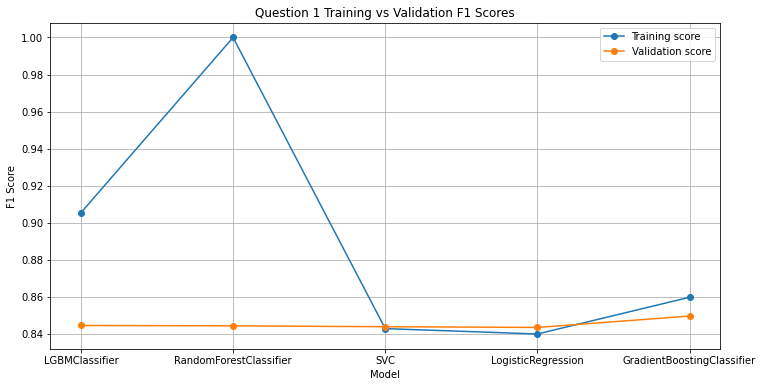

### q_no 2 grp 0-4


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 2: RandomForestClassifier with f1 score: 0.988201565773514


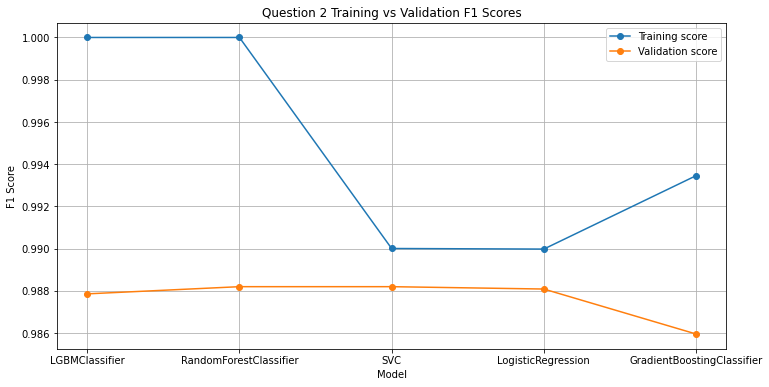

### q_no 3 grp 0-4


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 3: SVC with f1 score: 0.9670156478667117


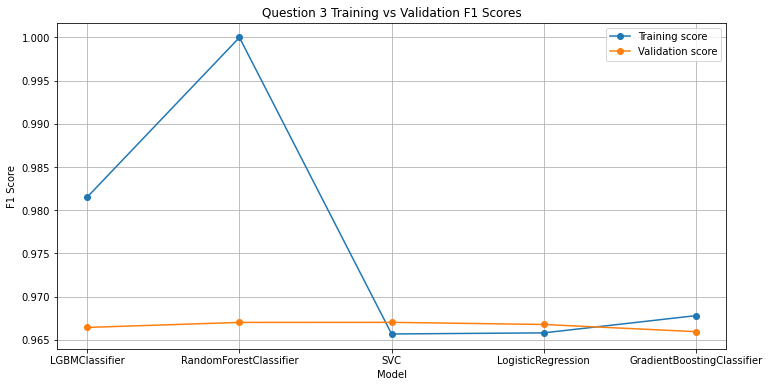

### q_no 4 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 4: RandomForestClassifier with f1 score: 0.8990390615250218


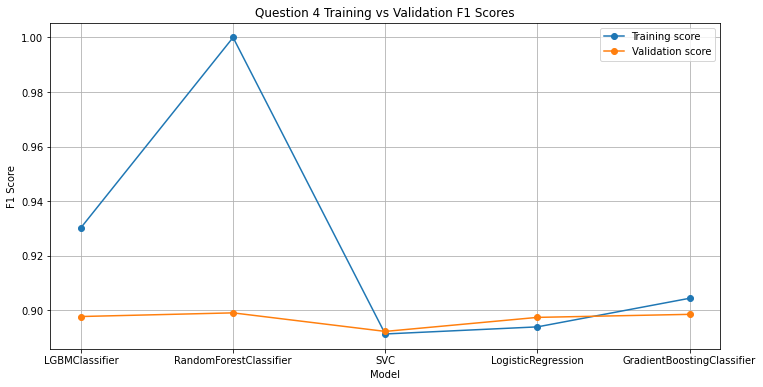

### q_no 5 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 5: SVC with f1 score: 0.6991316192746467


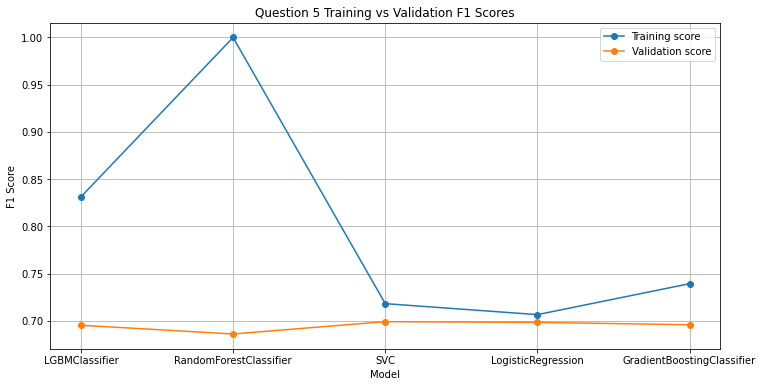

### q_no 6 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 6: GradientBoostingClassifier with f1 score: 0.885064690365532


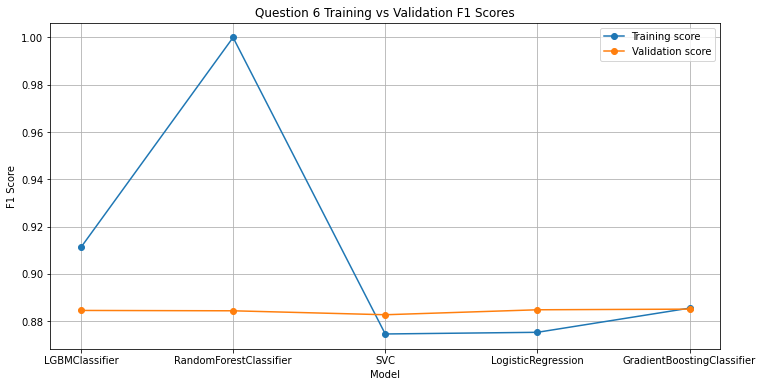

### q_no 7 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 7: SVC with f1 score: 0.8442932728647013


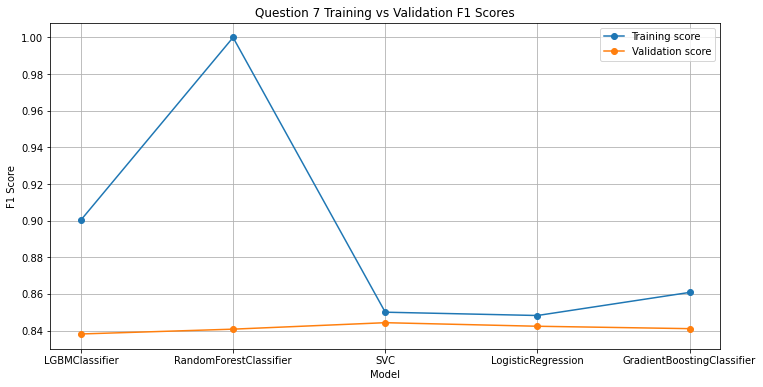

### q_no 8 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 8: SVC with f1 score: 0.7601406165494863


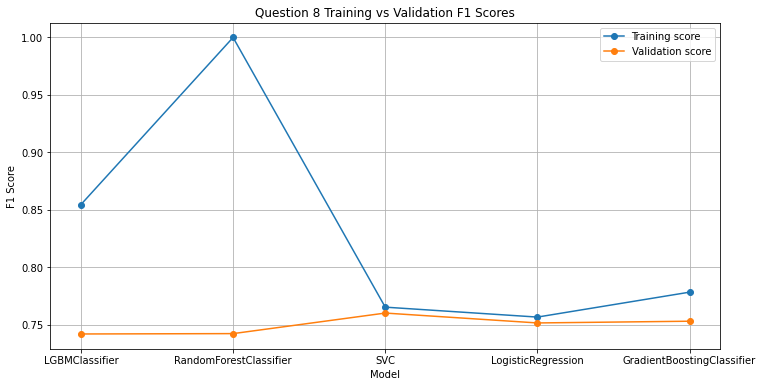

### q_no 9 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 9: SVC with f1 score: 0.847526255852208


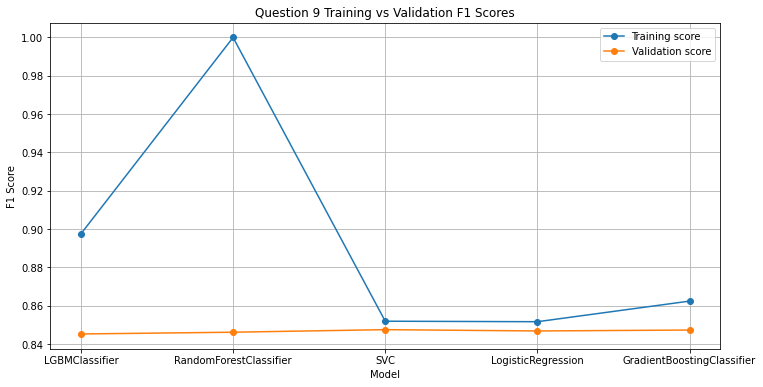

### q_no 10 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 10: GradientBoostingClassifier with f1 score: 0.6443309499489274


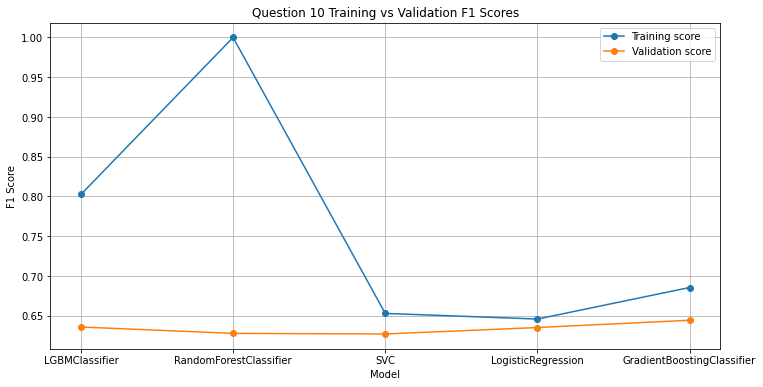

### q_no 11 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 11: SVC with f1 score: 0.7814551788824868


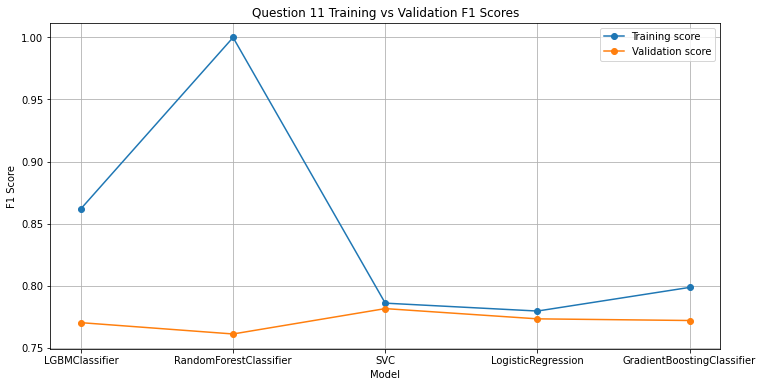

### q_no 12 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 12: SVC with f1 score: 0.9296628951358917


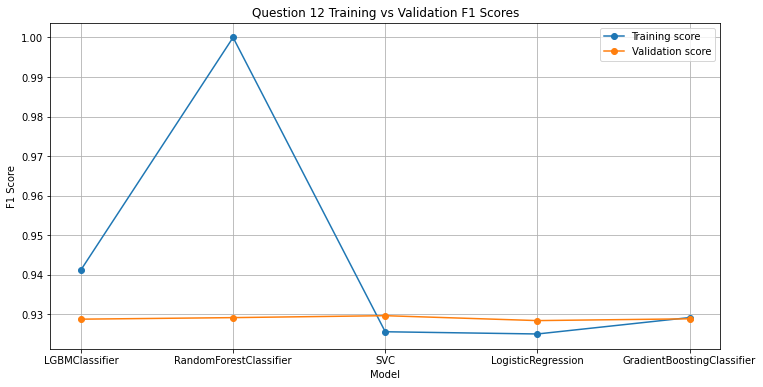

### q_no 13 grp 5-12


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 13: LGBMClassifier with f1 score: 0.2340686274509804


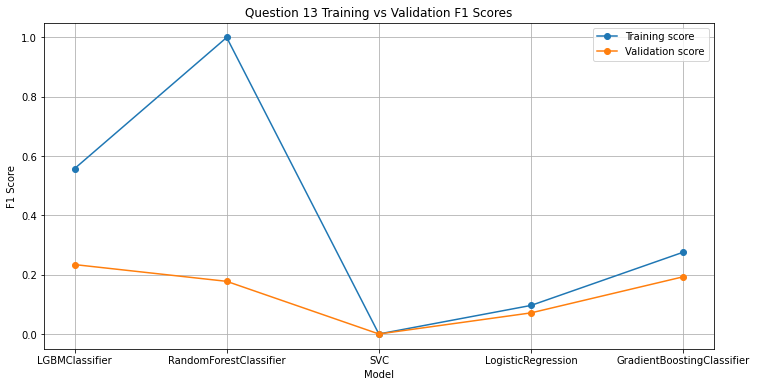

### q_no 14 grp 13-22


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 14: LogisticRegression with f1 score: 0.8356782585611892


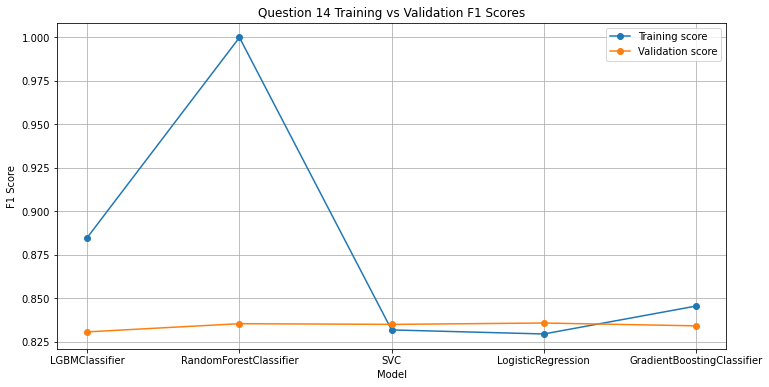

### q_no 15 grp 13-22


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 15: GradientBoostingClassifier with f1 score: 0.6482818997592471


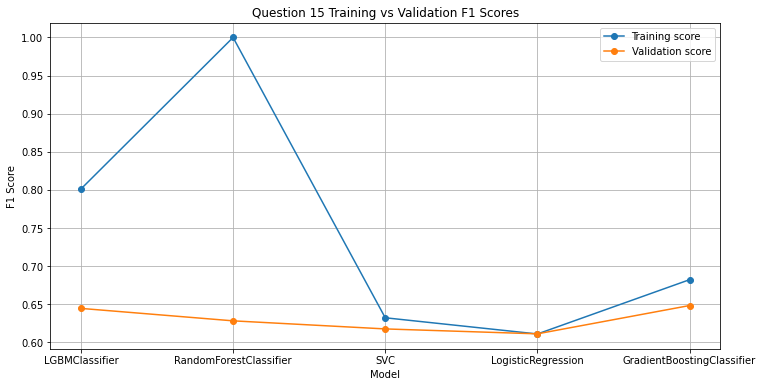

### q_no 16 grp 13-22


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 16: SVC with f1 score: 0.8521391043282462


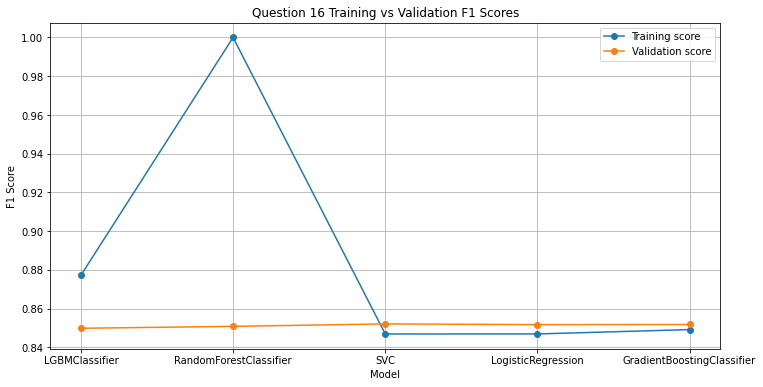

### q_no 17 grp 13-22


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 17: SVC with f1 score: 0.8147765435288039


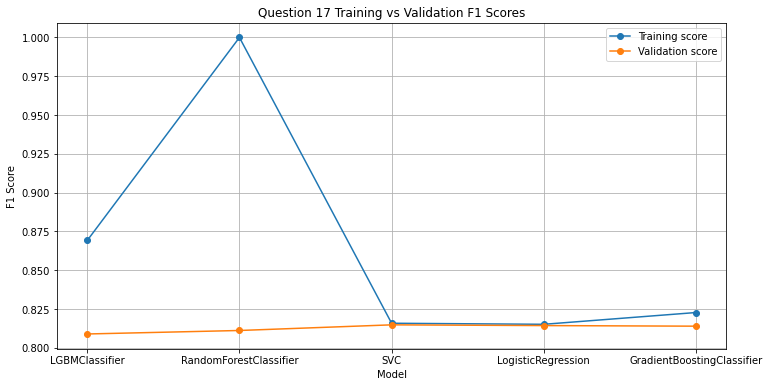

### q_no 18 grp 13-22


c:\Projects\EDA GSP\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model for question 18: RandomForestClassifier with f1 score: 0.9752066115702479


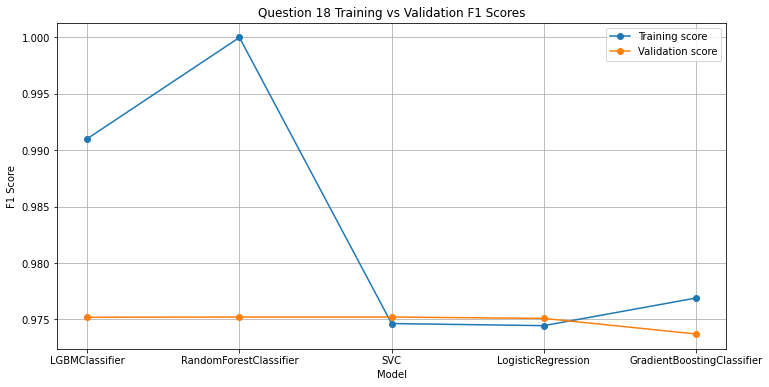

In [43]:
for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_df_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    max_score = -1
    best_model = None
    train_scores = []
    valid_scores = []

    for model in model_list:
        # Fit model on training data
        model.fit(train_df, train_labels['correct'])

        # Evaluate model on training data and validation data
        train_score = f1_score(train_labels['correct'], model.predict(train_df))
        valid_score = f1_score(valid_df_labels['correct'], model.predict(valid_df))

        # Store scores
        train_scores.append(train_score)
        valid_scores.append(valid_score)

        if valid_score > max_score:
            max_score = valid_score
            best_model = model
            models[f'{grp}_{q_no}'] = best_model

    print(f'Best model for question {q_no}: {type(best_model).__name__} with f1 score: {max_score}')

    prediction = best_model.predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = prediction.flatten()

    # Plot training vs validation scores
    model_names = [type(model).__name__ for model in model_list]
    plt.figure(figsize=(12, 6))
    plt.plot(model_names, train_scores, 'o-', label='Training score')
    plt.plot(model_names, valid_scores, 'o-', label='Validation score')
    plt.title(f'Question {q_no} Training vs Validation F1 Scores')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [100]:
model_list_2 = [LGBMClassifier(), RandomForestClassifier(), SVC(), LogisticRegression(), GradientBoostingClassifier()]

In [ ]:
for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_df_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    scaler = StandardScaler()
    train_df = scaler.fit_transform(train_df)
    valid_df = scaler.transform(valid_df)

    max_score = -1
    best_model = None
    train_scores_2 = []
    valid_scores_2 = []

    for model in model_list_2:
        # Fit model on training data
        model.fit(train_df, train_labels['correct'])

        # Evaluate model on training data and validation data
        train_score = f1_score(train_labels['correct'], model.predict(train_df))
        valid_score = f1_score(valid_df_labels['correct'], model.predict(valid_df))

        # Store scores
        train_scores_2.append(train_score)
        valid_scores_2.append(valid_score)

        if valid_score > max_score:
            max_score = valid_score
            best_model = model
            models[f'{grp}_{q_no}'] = best_model

    print(f'Best model for question {q_no}: {type(best_model).__name__} with f1 score: {max_score}')

    prediction = best_model.predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = prediction.flatten()

    # Plot training vs validation scores
    model_names = [type(model).__name__ for model in model_list_2]
    plt.figure(figsize=(12, 6))
    plt.plot(model_names, train_scores_2, 'o-', label='Training score')
    plt.plot(model_names, valid_scores_2, 'o-', label='Validation score')
    plt.title(f'Question {q_no} Training vs Validation F1 Scores')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [44]:
models

{'0-4_1': GradientBoostingClassifier(),
 '0-4_2': RandomForestClassifier(),
 '0-4_3': SVC(),
 '5-12_4': RandomForestClassifier(),
 '5-12_5': SVC(),
 '5-12_6': GradientBoostingClassifier(),
 '5-12_7': SVC(),
 '5-12_8': SVC(),
 '5-12_9': SVC(),
 '5-12_10': GradientBoostingClassifier(),
 '5-12_11': SVC(),
 '5-12_12': SVC(),
 '5-12_13': LGBMClassifier(),
 '13-22_14': LogisticRegression(),
 '13-22_15': GradientBoostingClassifier(),
 '13-22_16': SVC(),
 '13-22_17': SVC(),
 '13-22_18': RandomForestClassifier()}

In [28]:
models_2 = {}

In [ ]:
# Definir los valores de los hiperparámetros para buscar
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

f1_scores = []  # Aquí almacenaremos todos los f1_score

for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_df_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    # Creamos el modelo SVC
    svc = SVC()

    # Aplicamos GridSearchCV
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(train_df, train_labels['correct'])

    # Obtenemos el mejor modelo
    best_model = grid_search.best_estimator_

    # Evaluamos el mejor modelo en los datos de validación
    valid_score = f1_score(valid_df_labels['correct'], best_model.predict(valid_df))

    # Almacenamos el mejor modelo
    models_2[f'{grp}_{q_no}'] = best_model

    # Almacenamos el f1_score
    f1_scores.append(valid_score)

    print(f'Best model for question {q_no}: SVC with parameters {grid_search.best_params_} and f1 score: {valid_score}')

    prediction = models_2[f'{grp}_{q_no}'].predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = prediction.flatten()

# Calculamos la media de los f1_score
print('F1 Score medio: ', np.mean(f1_scores))

In [29]:
# Definir los valores de los hiperparámetros para buscar

f1_scores = []  # Aquí almacenaremos todos los f1_score

for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_df_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    # Creamos el modelo SVC
    svc = SVC()

    svc.fit(train_df, train_labels['correct'])
    # # Aplicamos RandomizedSearchCV
    # randomized_search = RandomizedSearchCV(svc, param_grid, n_iter=3, cv=3, scoring='f1', n_jobs=-1)
    # randomized_search.fit(train_df, train_labels['correct'])

    # # Obtenemos el mejor modelo
    # best_model = randomized_search.best_estimator_

    # Evaluamos el mejor modelo en los datos de validación
    # valid_score = f1_score(valid_df_labels['correct'], best_model.predict(valid_df))
    valid_score = f1_score(valid_df_labels['correct'], svc.predict(valid_df))

    # Almacenamos el mejor modelo
    models_2[f'{grp}_{q_no}'] = svc

    # Almacenamos el f1_score
    f1_scores.append(valid_score)

    print(f'Best model for question {q_no}: SVC with f1 score: {valid_score}')

    prediction = models_2[f'{grp}_{q_no}'].predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = prediction.flatten()

# Calculamos la media de los f1_score
print('F1 Score medio: ', np.mean(f1_scores))


### q_no 1 grp 0-4
Best model for question 1: SVC with f1 score: 0.843895678467935
### q_no 2 grp 0-4
Best model for question 2: SVC with f1 score: 0.988201565773514
### q_no 3 grp 0-4
Best model for question 3: SVC with f1 score: 0.9670156478667117
### q_no 4 grp 5-12
Best model for question 4: SVC with f1 score: 0.8922403308197518
### q_no 5 grp 5-12
Best model for question 5: SVC with f1 score: 0.6991316192746467
### q_no 6 grp 5-12
Best model for question 6: SVC with f1 score: 0.882691131498471
### q_no 7 grp 5-12
Best model for question 7: SVC with f1 score: 0.8442932728647013
### q_no 8 grp 5-12
Best model for question 8: SVC with f1 score: 0.7601406165494863
### q_no 9 grp 5-12
Best model for question 9: SVC with f1 score: 0.847526255852208
### q_no 10 grp 5-12
Best model for question 10: SVC with f1 score: 0.6270588235294117
### q_no 11 grp 5-12
Best model for question 11: SVC with f1 score: 0.7814551788824868
### q_no 12 grp 5-12
Best model for question 12: SVC with f1 score: 

In [ ]:
# Definir los valores de los hiperparámetros para buscar

f1_scores = []  # Aquí almacenaremos todos los f1_score

for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)

    # Select the appropriate dataframes based on the group
    train_df, valid_df = dataframes[grp]

    train_df = train_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]
    valid_df = valid_df[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_df.index]
    valid_df_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_df.index]

    # Creamos el modelo SVC
    svc = SVC()

    svc.fit(train_df, train_labels['correct'])
    valid_score = f1_score(valid_df_labels['correct'], svc.predict(valid_df))

    # Almacenamos el mejor modelo
    models_2[f'{grp}_{q_no}'] = svc

    # Almacenamos el f1_score
    f1_scores.append(valid_score)

    print(f'Best model for question {q_no}: SVC with f1 score: {valid_score}')

    prediction = models_2[f'{grp}_{q_no}'].predict(valid_df)
    prediction_df.loc[valid_df.index, q_no - 1] = prediction.flatten()

# Calculamos la media de los f1_score
print('F1 Score medio: ', np.mean(f1_scores))


In [30]:
models_2

{'0-4_1': SVC(),
 '0-4_2': SVC(),
 '0-4_3': SVC(),
 '5-12_4': SVC(),
 '5-12_5': SVC(),
 '5-12_6': SVC(),
 '5-12_7': SVC(),
 '5-12_8': SVC(),
 '5-12_9': SVC(),
 '5-12_10': SVC(),
 '5-12_11': SVC(),
 '5-12_12': SVC(),
 '5-12_13': SVC(),
 '13-22_14': SVC(),
 '13-22_15': SVC(),
 '13-22_16': SVC(),
 '13-22_17': SVC(),
 '13-22_18': SVC()}

In [32]:
def save_models(models_dict, base_path='.', folder='models'):
    # Define the output directory
    output_dir = os.path.join(base_path, folder)
    if not os.path.exists(output_dir):  # create the directory if it doesn't exist
        os.makedirs(output_dir)
    
    # Iterate over the models in the dictionary
    for key, model in models_dict.items():
        # Extract the model number from the key
        model_num = key.split('_')[-1]
        
        # Define the output file path
        output_file = os.path.join(output_dir, f'SVC_{model_num}.pkl')
        
        # Save the model to a pickle file
        with open(output_file, 'wb') as f:
            pickle.dump(model, f)

In [33]:
# Then you can call this function with your dictionary like this:
save_models(models_2, base_path=full_path)

In [34]:
models_2["0-4_1"]

SVC()

In [58]:
labels

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [59]:
VALID_USER_LIST

Index([22050317282090390, 22020410301178670, 21050007591270176,
       22070017182983470, 22030311070130930, 21040508274303176,
       20100510223839770, 21070510391133720, 21040216234285370,
       21030209222488860,
       ...
       21000509420338212, 21100313504764316, 21010415370725316,
       22080216152194430, 21040212461167524, 21040410403281456,
       22060321213062630, 21010211594453184, 20100411140929120,
       21090207050867936],
      dtype='int64', name='session_id', length=4588)

In [62]:
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

In [63]:
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    y_pred = (prediction_df.values.reshape((-1)) > threshold).astype('int')
    score = f1_score(true_df.values.reshape((-1)), y_pred, average="weighted")
    if score > max_score:
        max_score = score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.4 	F1 score  0.7092921246091639


In [67]:
predict_proba_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

for q_no in range(1, 19):

    # Select level group for the question based on the q_no.
    if q_no <= 3: grp = '0-4'
    elif q_no <= 13: grp = '5-12'
    elif q_no <= 22: grp = '13-22'

    # Select the appropriate dataframes based on the group
    _, valid_df_pr = dataframes[grp] # Solo necesitamos el conjunto de validación

    valid_df_pr = valid_df_pr[(filtered_importances_df[q_no][filtered_importances_df[q_no]!=0]).index.values]

    # Recuperamos el modelo correspondiente
    svc = models_2[f'{grp}_{q_no}']

    # Predecimos las probabilidades y tomamos la columna correspondiente a la clase '1'
    probabilities = svc.predict_proba(valid_df_pr)[:, 1]

    # Asignamos las probabilidades en el dataframe
    predict_proba_df.loc[valid_df_pr.index, q_no - 1] = probabilities

AttributeError: predict_proba is not available when  probability=False

Best threshold  0.4 	F1 score  0.7092921246091639


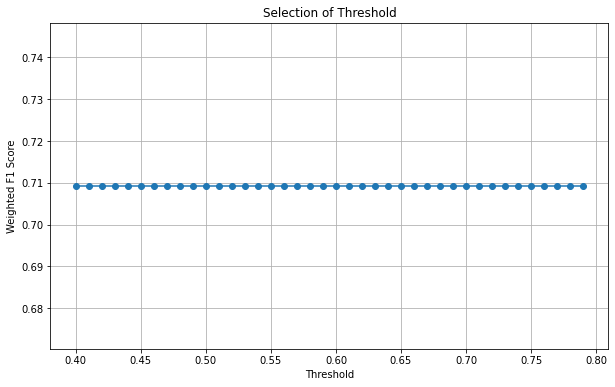

In [64]:
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Crear listas para almacenar los resultados para cada umbral
thresholds = []
scores = []

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    y_pred = (prediction_df.values.reshape((-1)) > threshold).astype('int')
    score = f1_score(true_df.values.reshape((-1)), y_pred, average="weighted")
    
    # Agregar los resultados a las listas
    thresholds.append(threshold)
    scores.append(score)
    
    if score > max_score:
        max_score = score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

# Plotear los resultados
plt.figure(figsize=(10,6))
plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Weighted F1 Score')
plt.title('Selection of Threshold')
plt.grid(True)
plt.show()


Best threshold  0.4 	F1 score  0.6164351452487046


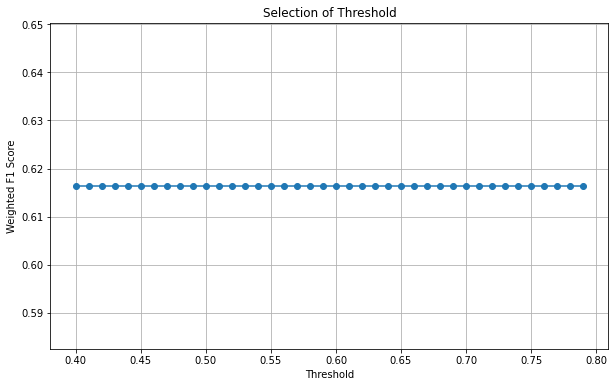

In [65]:
import matplotlib.pyplot as plt

true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Crear listas para almacenar los resultados para cada umbral
thresholds = []
scores = []

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    y_pred = (prediction_df.values.reshape((-1)) > threshold).astype('int')
    score = f1_score(true_df.values.reshape((-1)), y_pred, average="macro")
    
    # Agregar los resultados a las listas
    thresholds.append(threshold)
    scores.append(score)
    
    if score > max_score:
        max_score = score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

# Plotear los resultados
plt.figure(figsize=(10,6))
plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Weighted F1 Score')
plt.title('Selection of Threshold')
plt.grid(True)
plt.show()


In [68]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

In [70]:
for grp, (start, end) in limits.items():
    print(grp)
    print(str(start) +" "+str(end))
    print()
    for t in range(start, end):
        print(t)
        print()

0-4
1 4

1

2

3

5-12
4 14

4

5

6

7

8

9

10

11

12

13

13-22
14 19

14

15

16

17

18



# Features Importance